#### Import python packages to be used

In [1]:
import random, numpy as np, math, copy, matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from tqdm import tqdm
from numba import njit, prange,vectorize, cuda
from numba.typed import List
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

# Ant Colony Optimization Algorithm

Update Methods: 

*   ib_pheroupdate: Iteration Best Update, S*upd* <- arg max F(s) (to avoid premature converence, best 10(?) will be used)



In [13]:
#Iteration Best Update
@njit
def ib_pheroupdate(pheromone_maxtix,s_iter,total_list,ants):
  sort_index = np.argsort(np.asarray(total_list))
  #print(sort_index)
  #print(np.sort(vals))
  for index in range(ants*0.1):
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[sort_index[index]][jdex]
      y = s_iter[sort_index[index]][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[sort_index[index]]

Function to delete an element from a Numpy array that doesnt make Numba throw errors

In [14]:
@njit
def delete_workaround(arr, num):
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]


Ant Colony Optimization using adjacency matrices

In [15]:
#Start of ACO algo


@njit(fastmath = True)
def aco_func(pheromone_maxtix,cities_distance_matrix,num_cities,ants,alpha,beta,update_func):
  s_iter = List()
  total_list = List()
  
  for i in prange(ants):
    total = 0.0;
    currentlocation = 0
    s = List()
    s.append(currentlocation)
    canVisit = np.arange(num_cities)
    #canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    canVisit = delete_workaround(canVisit, currentlocation)
    #print("start")
    while len(canVisit) !=0:
      probSum = 0
      probList = list()
      for value in canVisit:
        prob = (pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)
        probSum += prob
      if (probSum == 0):
        newcity = np.random.choice(canVisit)
      else:
        for value in canVisit:
          prob = ((pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)) / probSum
          probList.append(prob)
        cumulative_distribution = np.cumsum(np.asarray(probList))
        cumulative_distribution /= cumulative_distribution[-1]
        uniform_samples = np.random.rand(len(canVisit))
        index = np.searchsorted(cumulative_distribution, uniform_samples, side="right")
        newcity = canVisit[index[0]]
        
      #print("newcity:")
      #print(newcity)
      s.append(newcity)
      total += cities_distance_matrix[currentlocation][newcity]
      currentlocation = newcity
      canVisit =  delete_workaround(canVisit, currentlocation)

    s.append(0)
    total += cities_distance_matrix[0][currentlocation]  
    total_list.append(total)
    s_iter.append(s)

  #Pheromone Update
  update_func(pheromone_maxtix,s_iter,total_list,ants)

Go through Adjacency matrix and return the most optimal path found.

In [16]:
def aco_results(pheromone_maxtix,cities_distance_matrix,num_cities,cities):
    currentlocation = 0  #start at the randomly determined starting city
    total = 0   #counter for the total distance in the path taken
    route = []    #list to store the path taken
    canVisit = np.array(range(num_cities))
    canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    route.append(currentlocation) #append the starting position to the route

    #Each of the cities will be visited once, with the exception of the starting city, which we will return to
    for i in range(len(cities)-1):
        nextlocation = -1
        max = np.NINF
        for value in canVisit:
            if pheromone_maxtix[currentlocation][value] > max:
                max = pheromone_maxtix[currentlocation][value]
                nextlocation = value
        canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
        total += cities_distance_matrix[currentlocation][nextlocation] #adds the distance between the current city and the next city to the total
        route.append(nextlocation) #appends the next city to the route
        currentlocation = nextlocation #sets the current location to the next location
        canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation)) #drops the current city from the adjacency matrix since it can no longer be visited (with the exception of the return to the starting city)

    #return to the starting location at the end
    total += cities_distance_matrix[0][currentlocation] #find the distance from the last city visited to the starting location 
    route.append(0) #append the starting location to the route
    print(total)
    return route,total

# Christofides algorithm

In [17]:
def get_odds(min_span, node_length):
    vert_list = list()
    for node,degree in min_span.degree:
        if degree % 2 == 1:
            vert_list.append(node)
    return np.array(vert_list)

        

In [18]:
def remove_dupe_verticies(tour):

    tour_nodes = []
    tour_edges = []
    for node1,node2 in tour:
        if node1 not in tour_nodes:
            tour_nodes.append(node1)
    tour_nodes.append(tour[0][0])
    return tour_nodes

In [19]:
def christofides(distance_matrix,num_cities):
    min_span_tree = minimum_spanning_tree(distance_matrix).toarray() #create a minimum spanning tree
    min_span_tree = nx.from_numpy_matrix(min_span_tree) #convert numpy array to graph for easier accesability
    odd_verts = get_odds(min_span_tree,num_cities) #get nodes from MST with odd degrees
    subgraph_odds = nx.from_numpy_matrix(distance_matrix) #turn distance matrix into a graph and get subgraph with odd verts
    subgraph_odds = subgraph_odds.subgraph(odd_verts)
    
    invert_subgraph = nx.Graph(subgraph_odds)
    for (u, v, wt) in invert_subgraph.edges.data('weight'):
        wait = wt * (-1)
        invert_subgraph.add_edge(u,v,weight=wait)
    min_weight_perfect_match = nx.algorithms.matching.max_weight_matching(invert_subgraph, maxcardinality=True)
    min_weight_graph = subgraph_odds.edge_subgraph(min_weight_perfect_match)
    multigraph = nx.MultiGraph()
    multigraph.add_weighted_edges_from(min_weight_graph.edges.data('weight'))
    multigraph.add_weighted_edges_from(min_span_tree.edges.data('weight'))
    eulerian_tour = list(nx.eulerian_circuit(multigraph))
    final_tour = remove_dupe_verticies(eulerian_tour)
    return final_tour

In [20]:
def christofides_total(route,distance_matrix):
    total = 0
    for i in range(len(route)-1):
       total += distance_matrix[route[i]][route[i+1]]
    total += distance_matrix[route[len(route)-1]][route[0]]
    return route,total

# Nearest Neighbor Algorithm

In [21]:

#Heuristic algo - nearest neighbor
def nearest_neighbor(cities_distance_matrix,num_cities,cities):
    currentlocation = 0  #start at 0 just for easy comparison between ACO
    total = 0   #counter for the total distance in the path taken
    route = []    #list to store the path taken
    canVisit = np.array(range(num_cities))
    canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    route.append(currentlocation) #append the starting position to the route
    #Each of the cities will be visited once, with the exception of the starting city, which we will return to
    for i in range(len(cities)-1):
      nextlocation = -1
      min = np.Inf
      for value in canVisit:
        if cities_distance_matrix[currentlocation][value] < min:
          min = cities_distance_matrix[currentlocation][value]
          nextlocation = value
      #nextlocation = np.amin(cities_distance_matrix[currentlocation]) #using the adjacency matrix, finds the smallest value and returns the next city to be visited
      canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
      total += cities_distance_matrix[currentlocation][nextlocation] #adds the distance between the current city and the next city to the total
      route.append(nextlocation) #appends the next city to the route
      currentlocation = nextlocation #sets the current location to the next location
      canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation)) #drops the current city from the adjacency matrix since it can no longer be visited (with the exception of the return to the starting city)

    #return to the starting location at the end
    total += cities_distance_matrix[0][currentlocation] #find the distance from the last city visited to the starting location 
    route.append(0) #append the starting location to the route
    return route,total

# Run Tests for all Algorithms

Will run each algorithm with 3 varing difficulty datasets. 
The datasets will be city sizes 15,48,128 and each algorithm will be timed 

### Create Tests for 48 cities

In [91]:
num_cities = 48
#read in xy, and distance datasets
tempdf = pd.read_csv('48_xy.csv',header=None)
tempdf2 = pd.read_csv('48_distancematrix.csv',header=None)

#convert from DF to numpy arrays
cities_48 = tempdf.to_numpy()
distance_matrix_48 = tempdf2.to_numpy()

Parameters for ACO with 48 cities


In [23]:
maxIterations = 30000
ants= 100
alpha = 1
beta = 0.5

pheromone_maxtix_48 = np.zeros(shape=(num_cities,num_cities))

#run ACO for 50 cities
for iteration in tqdm(range(maxIterations)):
  aco_func(pheromone_maxtix_48,distance_matrix_48,num_cities,ants,alpha,beta,ib_pheroupdate)

aco_48 = aco_results(pheromone_maxtix_48,distance_matrix_48,num_cities,cities_48)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [08:25<00:00, 59.34it/s]

40292


Run Nearest Neighbor with 48 Cities

In [24]:
nearest_48 = nearest_neighbor(distance_matrix_48,num_cities,cities_48)

In [92]:
%timeit nearest_48 = nearest_neighbor(distance_matrix_48,num_cities,cities_48)

2.44 ms ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Run Christofides with 48 cities

In [25]:
christofides_48 = christofides(distance_matrix_48, num_cities)
christofides_48 = christofides_total(christofides_48,distance_matrix_48)

In [93]:
%timeit christofides_48 = christofides(distance_matrix_48, num_cities)

44.5 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Create Tests for 15 cities

In [128]:
num_cities = 15
#read in xy, and distance datasets
tempdf = pd.read_csv('15_xy.csv',header=None)
tempdf2 = pd.read_csv('15_distancematrix.csv',header=None)

#convert from DF to numpy arrays
cities_15 = tempdf.to_numpy()
distance_matrix_15 = tempdf2.to_numpy()

Parameters for ACO with 15 cities


In [129]:
maxIterations = 30000
ants= 100
alpha = 1
beta = 0.5

pheromone_maxtix_15 = np.zeros(shape=(num_cities,num_cities))

#run ACO for 50 cities
for iteration in tqdm(range(maxIterations)):
  aco_func(pheromone_maxtix_15,distance_matrix_15,num_cities,ants,alpha,beta,ib_pheroupdate)

aco_15 = aco_results(pheromone_maxtix_15,distance_matrix_15,num_cities,cities_15)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:39<00:00, 301.39it/s]

307


Run Nearest Neighbor with 15 Cities

In [114]:
#for iteration in tqdm(range(1)):
nearest_15 = nearest_neighbor(distance_matrix_15,num_cities,cities_15)

In [115]:
%timeit nearest_15 = nearest_neighbor(distance_matrix_15,num_cities,cities_15)

537 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Run Christofides with 15 cities

In [116]:
christofides_15 = christofides(distance_matrix_15, num_cities)
christofides_15 = christofides_total(christofides_15,distance_matrix_15)

In [124]:
%timeit christofides_15 = christofides(distance_matrix_15, num_cities)

2.84 ms ± 6.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Create Tests for 59 cities

In [118]:
num_cities = 59
#read in xy, and distance datasets
tempdf = pd.read_csv('59_xy.csv',header=None)
tempdf2 = pd.read_csv('59_distancematrix.csv',header=None)

#convert from DF to numpy arrays
cities_59 = tempdf.to_numpy()
distance_matrix_59 = tempdf2.to_numpy()

Parameters for ACO with 59 cities


In [82]:
maxIterations = 30000
ants= 100
alpha = 1
beta = 0.5

pheromone_maxtix_59 = np.zeros(shape=(num_cities,num_cities))

#run ACO for 50 cities
for iteration in tqdm(range(maxIterations)):
  aco_func(pheromone_maxtix_59,distance_matrix_59,num_cities,ants,alpha,beta,ib_pheroupdate)

aco_59 = aco_results(pheromone_maxtix_59,distance_matrix_59,num_cities,cities_59)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:26<00:00, 32.37it/s]

1344


Run Nearest Neighbor with 59 Cities

In [119]:
#for iteration in tqdm(range(1)):
nearest_59 = nearest_neighbor(distance_matrix_59,num_cities,cities_59)

In [120]:
%timeit nearest_59 = nearest_neighbor(distance_matrix_59,num_cities,cities_59)

2.87 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Run Christofides with 10 cities

In [121]:
christofides_59 = christofides(distance_matrix_59, num_cities)
christofides_59 = christofides_total(christofides_59,distance_matrix_59)

In [123]:
%timeit christofides_59 = christofides(distance_matrix_59, num_cities)

59.3 ms ± 764 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Graph Results

In [101]:
def sortCitiesSolution(lst,cities):
    x = []
    y = []
    for val in lst:
        x.append(cities[val][0])
        y.append(cities[val][1])
    return (x,y)
    

### 15 Cities
#### 291 - optimal path

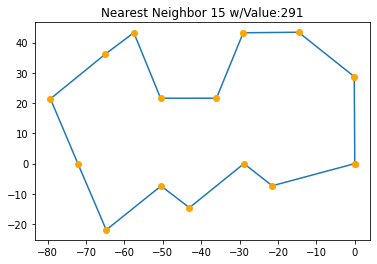

In [184]:
route,total = nearest_15
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route,cities_15)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_title("Nearest Neighbor 15 w/Value:" + str(total))
#plt.set_xticks(ind)
fig.savefig("nearestneighbor15.png")
plt.show()

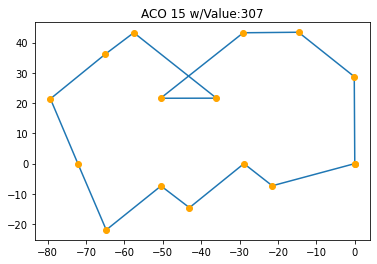

In [185]:
s_iter,total_list = aco_15
acoX,acoY = sortCitiesSolution(s_iter,cities_15)
fig,ax = plt.subplots()
plt.scatter(acoX,acoY,color='orange',zorder=1)
plt.plot(acoX,acoY,zorder=0)
title = "ACO 15 w/Value:" + str(total_list)
ax.set_title(title)
fig.savefig("ACO15.png")
plt.show()

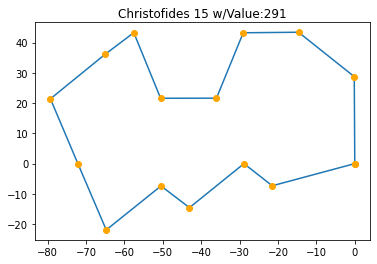

In [186]:
route,total = christofides_15
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route,cities_15)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)

ax.set_title('Christofides 15 w/Value:' + str(total))
#plt.set_xticks(ind)
fig.savefig("Christofides15.png")
plt.show()

### 48 Cities
#### 33523 - optimal path

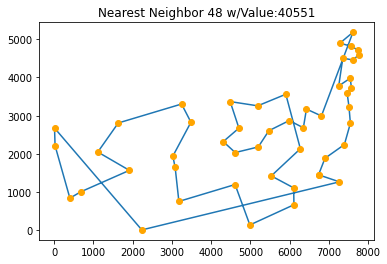

In [187]:
route,total = nearest_48
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route,cities_48)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)

ax.set_title("Nearest Neighbor 48 w/Value:" + str(total))
#plt.set_xticks(ind)
fig.savefig("nearestneighbor48.png")
plt.show()

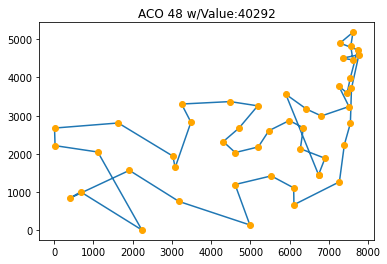

In [188]:
s_iter,total_list = aco_48
acoX,acoY = sortCitiesSolution(s_iter,cities_48)
fig,ax = plt.subplots()
plt.scatter(acoX,acoY,color='orange',zorder=1)
plt.plot(acoX,acoY,zorder=0)

title = "ACO 48 w/Value:" + str(total_list)
ax.set_title(title)
fig.savefig("ACO48.png")
plt.show()

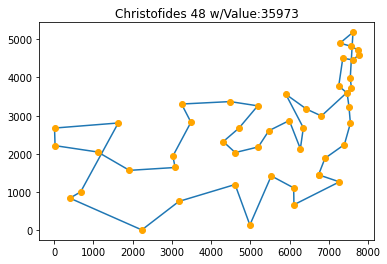

In [189]:
route,total = christofides_48
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route,cities_48)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)

ax.set_title('Christofides 48 w/Value:' + str(total))
#plt.set_xticks(ind)
fig.savefig("Christofides48.png")
plt.show()

### 59 Cities

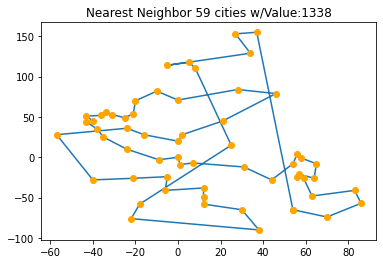

In [108]:
route,total = nearest_59
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route,cities_59)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_title("Nearest Neighbor 59 cities w/Value:" + str(total))
#plt.set_xticks(ind)
fig.savefig("nearestneighbor59.png")
plt.show()

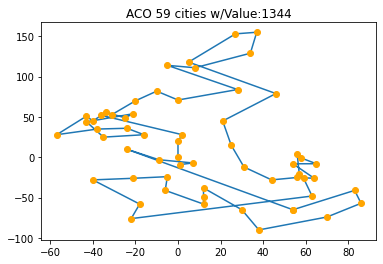

In [109]:
s_iter,total_list = aco_59
acoX,acoY = sortCitiesSolution(s_iter,cities_59)
fig,ax = plt.subplots()
plt.scatter(acoX,acoY,color='orange',zorder=1)
plt.plot(acoX,acoY,zorder=0)
title = "ACO 59 cities w/Value:" + str(total_list)
ax.set_title(title)
fig.savefig("ACO59.png")
plt.show()

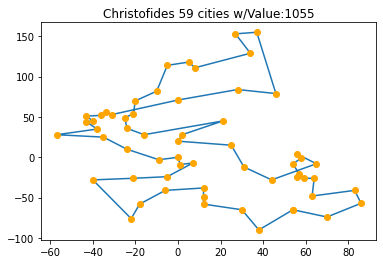

In [110]:
route,total = christofides_59
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route,cities_59)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_title('Christofides 59 cities w/Value:' + str(total))
#plt.set_xticks(ind)
fig.savefig("Christofides59.png")
plt.show()

In [165]:
nearest_times = [0.537,2.44,2.87]
christofides_times = [2.87,4.550,58.500]
aco_times = [99000,505000,926000]
y = ['nearest neighbor','christofides']
x = [0.537,2.87]
x2= [2.44,4.55]
x3 = [2.87,58.5]

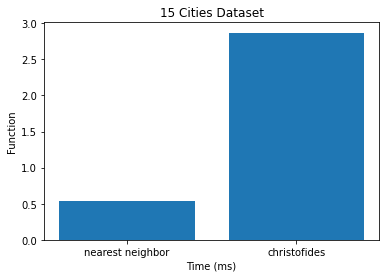

In [174]:
fig,ax = plt.subplots()
plt.bar(y,x)
ax.set_ylabel('Function')
ax.set_xlabel('Time (ms)')
ax.set_title('15 Cities Dataset')
fig.savefig("15cities.png")# show the graph
plt.show()

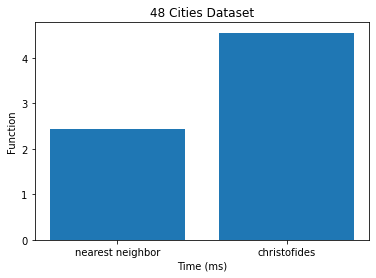

In [175]:
fig,ax = plt.subplots()
plt.bar(y,x2)
ax.set_ylabel('Function')
ax.set_xlabel('Time (ms)')
ax.set_title('48 Cities Dataset')
fig.savefig("48cities.png")# show the graph
plt.show()

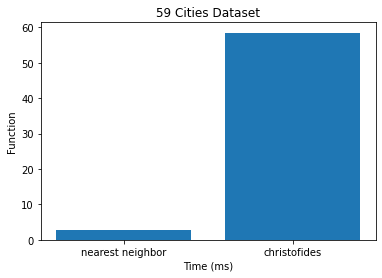

In [176]:
fig,ax = plt.subplots()
plt.bar(y,x3)
ax.set_ylabel('Function')
ax.set_xlabel('Time (ms)')
ax.set_title('59 Cities Dataset')
fig.savefig("59cities.png")# show the graph
plt.show()